# Pneumonia Detection Challenge 

###Project Description
  Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs. 

### Data Description



1.   stage_2_train.csv - This is the training set. Contains patientIds and bounding box / target information.
2.   stage_2_detailed_class_info.csv - provides detailed information about the type of positive or negative class for each image.
3. stage_2_train_images - Images for training. Total 26,684 dicom images. 
4. stage_2_test_images - Images for testing. Total 3000 dicom images.

5.   Data Fields
> 1.   **patientId** - A patientId. Each patientId corresponds to a unique image.\n
> 2.   **x** - the upper-left x coordinate of the bounding box.
> 3. **y** - the upper-left y coordinate of the bounding box.
> 4. **width** - the width of the bounding box.
> 5. **height** - the height of the bounding box.
> 6. **Target** - the binary Target, indicating whether this sample has evidence of pneumonia.
> 7. **class** - Normal, No Lung Opacity / Not Normal, Lung Opacity









In [ ]:
!pip install pydicom #We are going to use pydicom package for dicom images processing.

     |████████████████████████████████| 35.5MB 1.2MB/s 


In [ ]:
#import necessory packages
import os
import csv
import random
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
from skimage import io
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import pydicom
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive #mount google drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Capstone My Data') #Change working directory

In [ ]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv') #Load csv files
train_labels_df = pd.read_csv('stage_2_train_labels.csv')    

In [ ]:
train_labels_df.shape #Print shape of train_labels_df

(30227, 6)

In [ ]:
class_info_df.shape #Print shape of class_info_df

(30227, 2)

In [ ]:
class_info_df.head(5) #print 5 records

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [ ]:
train_labels_df.head(5) #print 5 records

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

#### 1. Missing Values

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

In [ ]:
missing_data(train_labels_df[train_labels_df['Target']==0]) #Normal 

height    width        y        x  Target  patientId
Total    20672.0  20672.0  20672.0  20672.0     0.0        0.0
Percent    100.0    100.0    100.0    100.0     0.0        0.0

In [ ]:
missing_data(train_labels_df[train_labels_df['Target']==1]) # Positive 

Target  height  width    y    x  patientId
Total       0.0     0.0    0.0  0.0  0.0        0.0
Percent     0.0     0.0    0.0  0.0  0.0        0.0

In [ ]:
missing_data(class_info_df)

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

#### 2. Data distribution

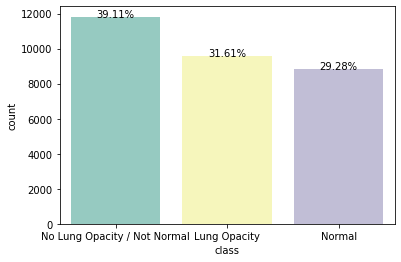

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [ ]:
def get_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()
    # Get total number of samples
    total_samples = len(data)
    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))


In [ ]:
get_distribution(class_info_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


#### 3. Merge two data frames

In [ ]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [ ]:
train_class_df.head(5)

patientId  ...                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity

[5 rows x 7 columns]

#### 4. Explore merged data set

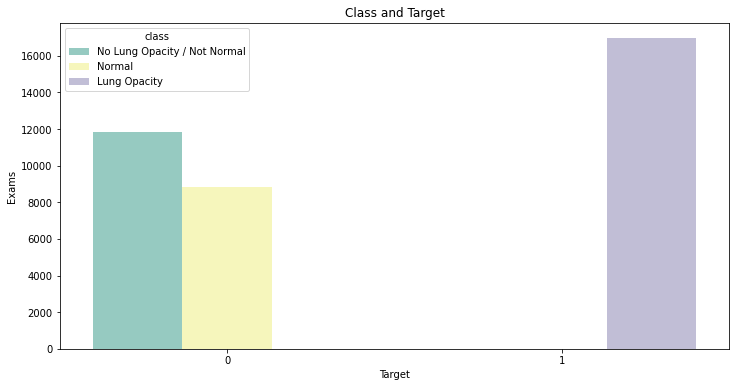

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Class and Target")
plt.show()

#### Note - 

1. Target = 1 is associated with class: Lung Opacity.



2. Target = 0 are either of class: Normal or class: No Lung Opacity / Not Normal.

#### 5. Distribution of X, Y, height & width of Lung Opacity

<Figure size 432x288 with 0 Axes>

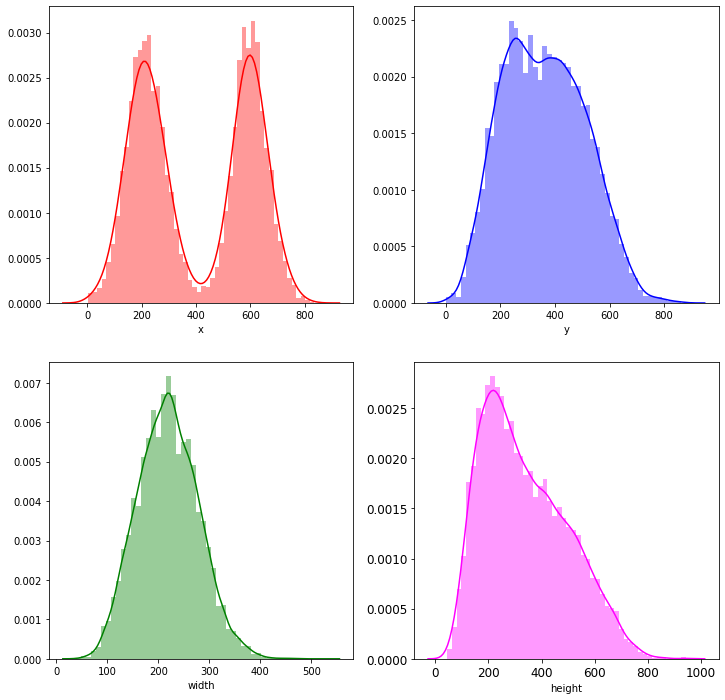

In [ ]:
target1 = train_class_df[train_class_df['Target']==1]
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#### 6. Explore images

In [ ]:
image_train_path = os.listdir('stage_2_train_images')
image_test_path = os.listdir('stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [ ]:
# Display image metadata
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# Show dom images 
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        #read dcm image
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'], age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

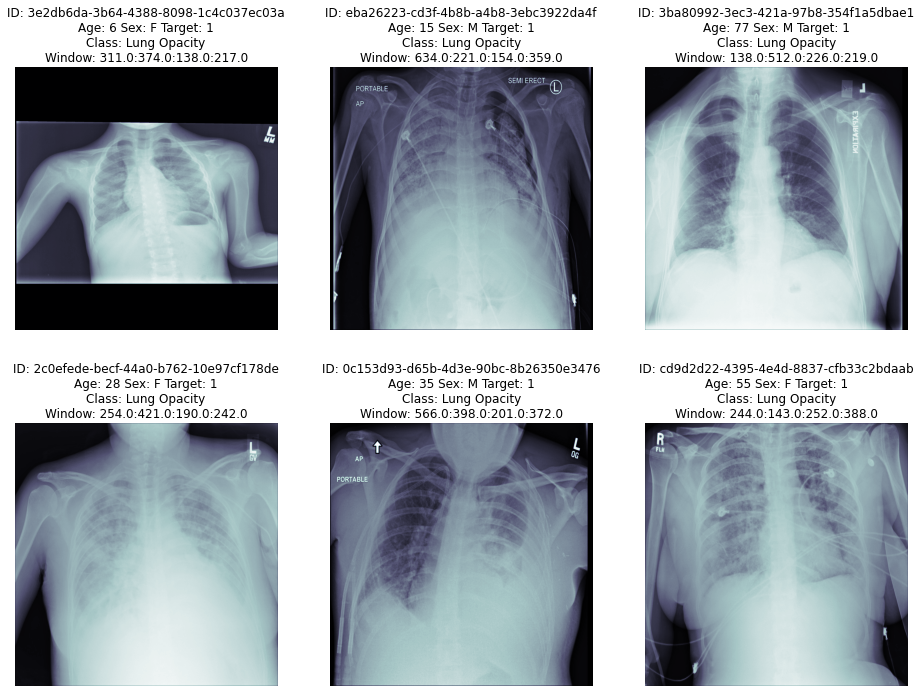

In [ ]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(6)) # for target 1

In [ ]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'], age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="red",alpha = 0.1))   
    plt.show()

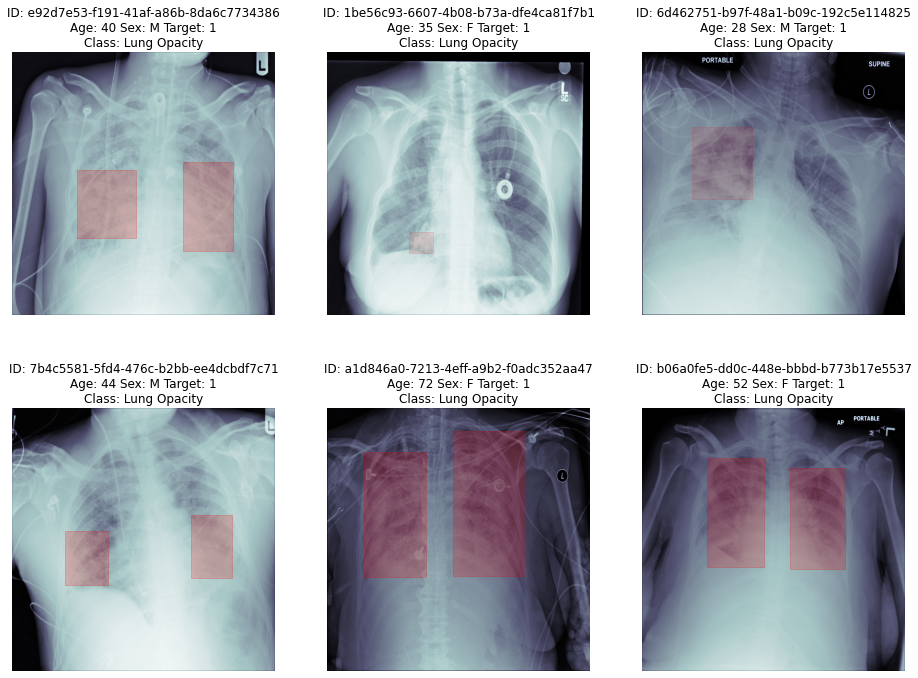

In [ ]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(6))

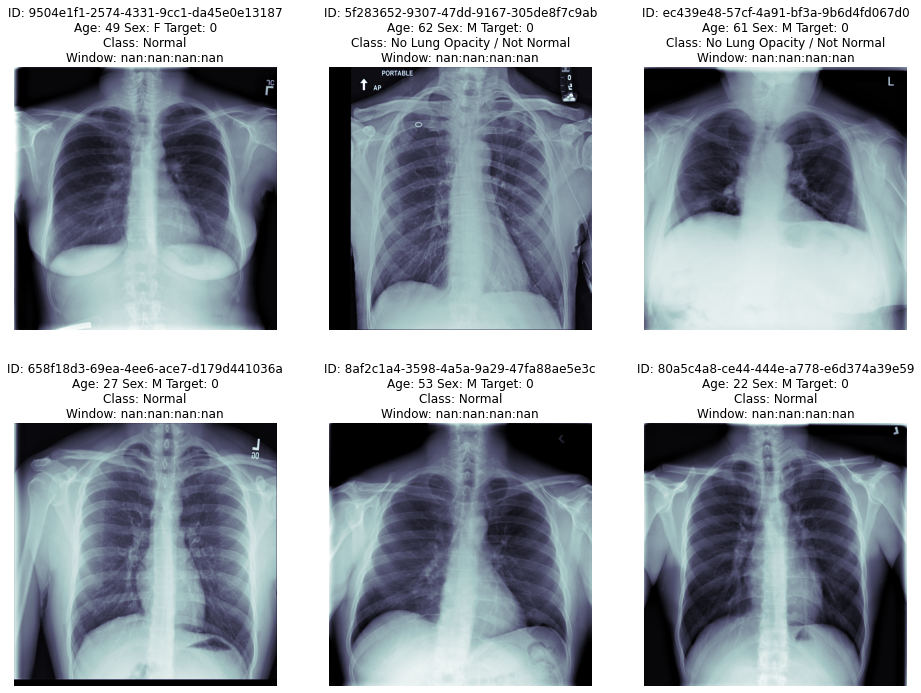

In [ ]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(6)) # Display images with target 0

## EDA Summary

1. We have total 26,684 images in training data set & 3000 images in testing dataset.
2. Target = 1 is associated with class: Lung Opacity.

3. Target = 0 are either of class: Normal or class: No Lung Opacity

4. There is no x,y,width & height value for records with Target 0.

5. There are two gaussian for x point distrubution graph. This respresent Lung opacity are in both left & righ lungs in given dataset.

#### 7. Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [ ]:
train_class_df["filenames"]=train_class_df['patientId']+'.dcm' # Create one more column for file name

In [ ]:
train_class_df.head()

patientId  ...                                 filenames
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  00322d4d-1c29-4943-afc9-b6754be640eb.dcm
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
4  00436515-870c-4b36-a041-de91049b9ab4  ...  00436515-870c-4b36-a041-de91049b9ab4.dcm

[5 rows x 8 columns]

In [ ]:
POSITIVE = train_class_df[train_class_df['Target']==1]
NEGATIVE = train_class_df[train_class_df['Target']==0]

In [ ]:
POSITIVE.shape

(16957, 8)

In [ ]:
NEGATIVE.shape

(20672, 8)

In [ ]:
#Use only 1.5K records per class for training.. as its taking time for training
records_for_training=1500
POSITIVE = POSITIVE[:records_for_training]
NEGATIVE = NEGATIVE[:records_for_training]

In [ ]:
training_df=pd.concat([POSITIVE,NEGATIVE])

In [ ]:
training_df.head()

patientId  ...                                 filenames
4   00436515-870c-4b36-a041-de91049b9ab4  ...  00436515-870c-4b36-a041-de91049b9ab4.dcm
5   00436515-870c-4b36-a041-de91049b9ab4  ...  00436515-870c-4b36-a041-de91049b9ab4.dcm
6   00436515-870c-4b36-a041-de91049b9ab4  ...  00436515-870c-4b36-a041-de91049b9ab4.dcm
7   00436515-870c-4b36-a041-de91049b9ab4  ...  00436515-870c-4b36-a041-de91049b9ab4.dcm
10  00704310-78a8-4b38-8475-49f4573b2dbb  ...  00704310-78a8-4b38-8475-49f4573b2dbb.dcm

[5 rows x 8 columns]

In [ ]:
filenames = list(training_df["filenames"])

In [ ]:
random.shuffle(filenames)

In [ ]:
# split into train and validation small set
n_valid_samples = 600
total_records_for_training=3000
train_filenames = filenames[n_valid_samples:total_records_for_training]
valid_filenames = filenames[:n_valid_samples]

In [ ]:
len(valid_filenames)

600

In [ ]:
len(train_filenames)

2400

 #### Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=2, image_size=128, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

#### ResNet

#### In traditional neural networks, more layers mean a better network but because of the vanishing gradient problem, weights of the first layer won’t be updated correctly through the back-propagation. As the error gradient is back-propagated to earlier layers, repeated multiplication makes the gradient small. Thus, with more layers in the networks, its performance gets saturated and starts decreasing rapidly. Res-Net solves this problem by using the identity matrix. When the back-propagation is done through identity function, the gradient will be multiplied only by 1. This preserves the input and avoids any loss in the information.



In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

#### Train Network

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


In [ ]:
# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
# create train and validation generators
folder = 'stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_file="4000_checkpoint.hdf5"
checkpoint = ModelCheckpoint(checkpoint_file,monitor='accuracy',verbose=1,save_best_only=True,mode='max',save_freq=1)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,checkpoint], epochs=6, workers=8, use_multiprocessing=True)

Epoch 1/6
78/78 [==============================] - 3584s 46s/step - loss: 0.5318 - accuracy: 0.8788 - mean_iou: 0.4122 - val_loss: 0.4704 - val_accuracy: 0.9058 - val_mean_iou: 0.4706 - lr: 0.0010
Epoch 2/6
78/78 [==============================] - 3646s 47s/step - loss: 0.4690 - accuracy: 0.9121 - mean_iou: 0.4808 - val_loss: 0.5787 - val_accuracy: 0.8078 - val_mean_iou: 0.2066 - lr: 9.9606e-04
Epoch 3/6
78/78 [==============================] - 3636s 47s/step - loss: 0.4485 - accuracy: 0.9164 - mean_iou: 0.5042 - val_loss: 0.4465 - val_accuracy: 0.9280 - val_mean_iou: 0.5568 - lr: 9.8429e-04
Epoch 4/6
78/78 [==============================] - 3641s 47s/step - loss: 0.4418 - accuracy: 0.9197 - mean_iou: 0.5098 - val_loss: 0.4483 - val_accuracy: 0.9212 - val_mean_iou: 0.5062 - lr: 9.6489e-04
Epoch 5/6
78/78 [==============================] - 3627s 47s/step - loss: 0.4233 - accuracy: 0.9241 - mean_iou: 0.5322 - val_loss: 0.4118 - val_accuracy: 0.9300 - val_mean_iou: 0.5509 - lr: 9.3815e-04

In [ ]:
model.load_weights("4000_checkpoint.hdf5")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_file="4000_checkpoint_1.hdf5"
checkpoint = ModelCheckpoint(checkpoint_file,monitor='accuracy',verbose=1,save_best_only=True,mode='max',save_freq=1)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,checkpoint], epochs=6, workers=8, use_multiprocessing=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/6

Epoch 00001: accuracy improved from -inf to 0.94644, saving model to 4000_checkpoint_1.hdf5
 1/78 [..............................] - ETA: 0s - loss: 0.3660 - accuracy: 0.9464 - mean_iou: 0.5925
Epoch 00001: accuracy did not improve from 0.94644
 2/78 [..............................] - ETA: 32:15 - loss: 0.4199 - accuracy: 0.9385 - mean_iou: 0.5853
Epoch 00001: accuracy did not improve from 0.94644
 3/78 [>.............................] - ETA: 41:55 - loss: 0.4499 - accuracy: 0.9325 - mean_iou: 0.5496
Epoch 00001: accuracy did not improve from 0.94644
 4/78 [>.............................] - ETA: 46:25 - loss: 0.4523 - accuracy: 0.9316 - mean_iou: 0.5151
Epoch 00001: accuracy did not improve from 0.94644
 5/78 [>.............................] - ETA: 48:44 - loss: 0.4461 - accuracy: 0.9328 - mean_iou: 0.4989
Epoch 00001: accuracy did not improve from 0.94644
 6/78 [=>............................] - ETA

In [ ]:
model_json = model.to_json()
with open("model4000_6.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("model4000_6.h5")

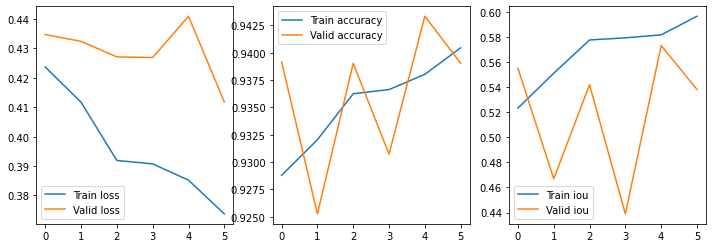

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,checkpoint], epochs=8, workers=8, use_multiprocessing=True,initial_epoch=6)

Epoch 7/8

Epoch 00007: accuracy improved from 0.94873 to 0.95261, saving model to 4000_checkpoint_1.hdf5
 1/78 [..............................] - ETA: 0s - loss: 0.3139 - accuracy: 0.9526 - mean_iou: 0.6516
Epoch 00007: accuracy did not improve from 0.95261
 2/78 [..............................] - ETA: 32:40 - loss: 0.3334 - accuracy: 0.9474 - mean_iou: 0.6426
Epoch 00007: accuracy did not improve from 0.95261
 3/78 [>.............................] - ETA: 42:48 - loss: 0.3425 - accuracy: 0.9447 - mean_iou: 0.6287
Epoch 00007: accuracy did not improve from 0.95261
 4/78 [>.............................] - ETA: 47:22 - loss: 0.3401 - accuracy: 0.9483 - mean_iou: 0.6380
Epoch 00007: accuracy did not improve from 0.95261
 5/78 [>.............................] - ETA: 49:39 - loss: 0.3496 - accuracy: 0.9482 - mean_iou: 0.6261
Epoch 00007: accuracy did not improve from 0.95261
 6/78 [=>............................] - ETA: 50:53 - loss: 0.3624 - accuracy: 0.9449 - mean_iou: 0.6133
Epoch 00007:

In [ ]:
model_json = model.to_json()
with open("model4000_8.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("model4000_8.h5")

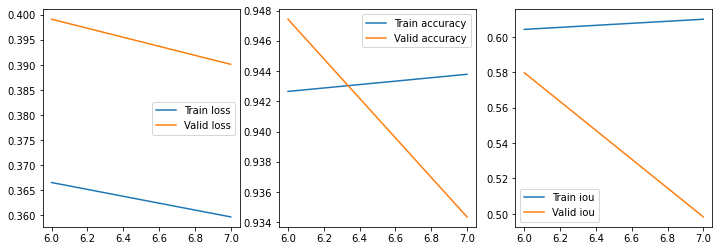

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

Above training we have done for additional 2 epochs. 

#### Prediction on validation set

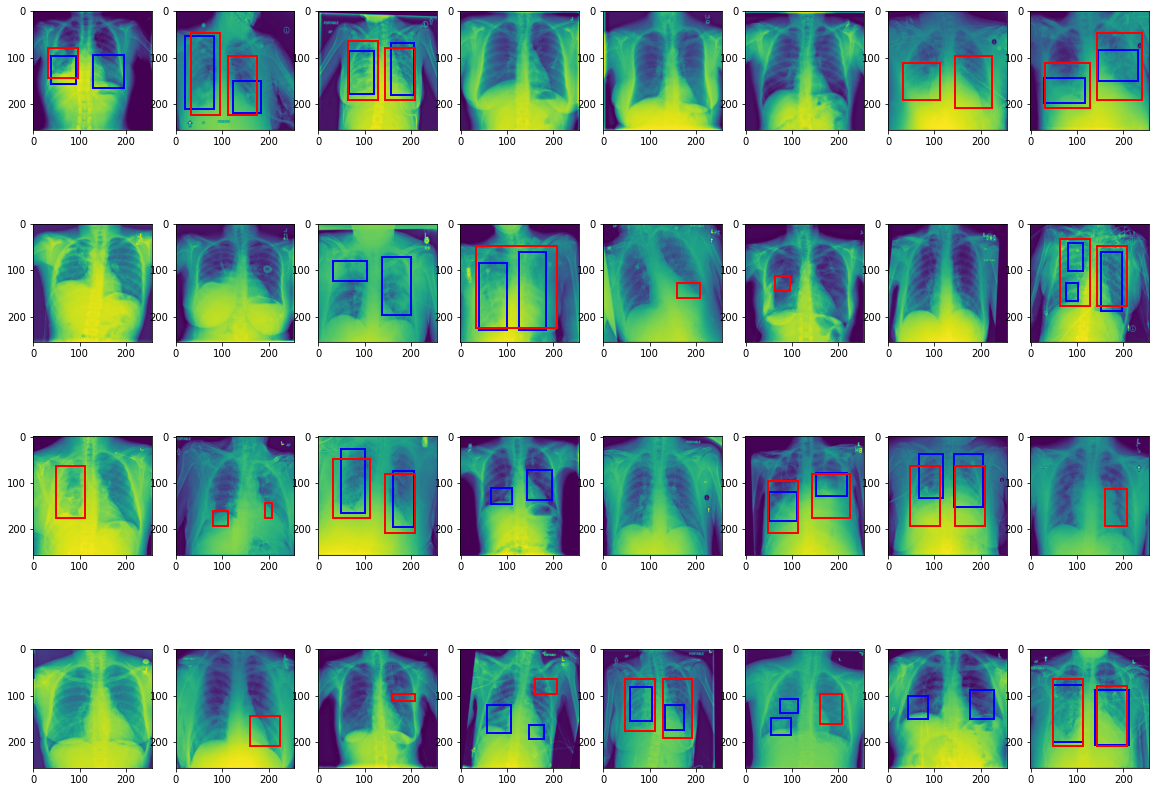

In [ ]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            conf = np.mean(pred[y:y+height, x:x+width])
            if conf>0.3:
              axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

#### Prediction on test set

In [ ]:
folder = 'stage_2_test_images'
test_filenames = os.listdir(folder)
# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=2, image_size=256, shuffle=False, predict=True)

n test samples: 3000


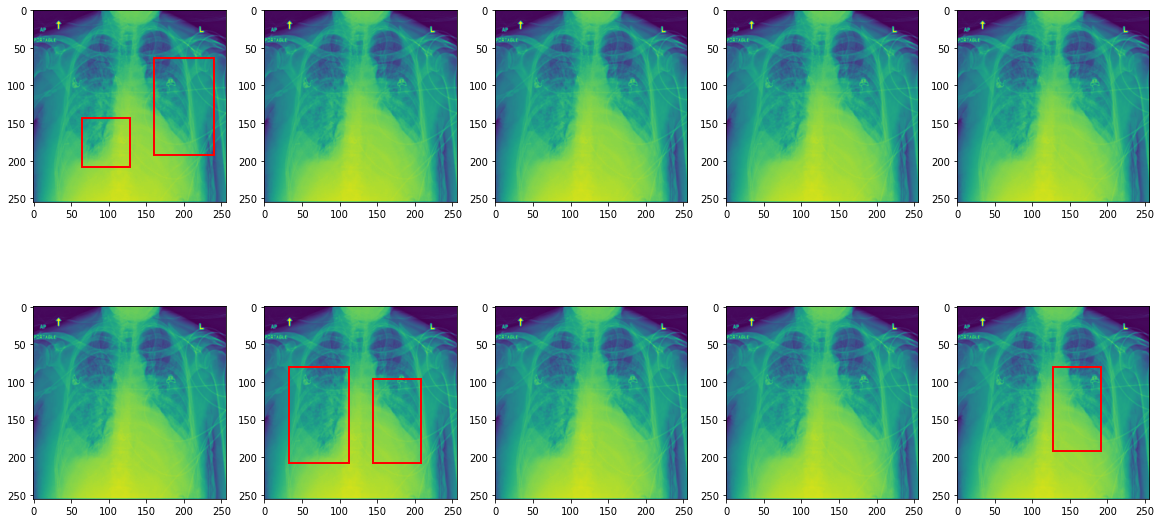

In [ ]:
print('n test samples:', len(test_filenames))
f, axarr = plt.subplots(2, 5, figsize=(20,10))
axarr = axarr.ravel()
axidx = 0
# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    #axarr[axidx].imshow(resize(img[:, :, 0],(1024, 1024),mode='reflect'))
    axarr[axidx].imshow(img[:, :, 0])
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        #pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            if conf>0.8:
              predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
              axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    #print("--------------------------------------------------------------------------")
    #print(axidx)
    #print(predictionString)
    axidx += 1
    if axidx >= 10: #len(test_filenames)
        break
plt.show()

# DenseNet121
DenseNet falls in the category of classic networks. DenseNet is quite similar to ResNet with some fundamental differences. ResNet uses an additive method (+) that merges the previous layer (identity) with the future layer, whereas DenseNet concatenates (.) the output of the previous layer with the future layer.

In [ ]:
from keras.layers import *
from keras.applications.densenet import DenseNet121
from keras.models import Model
base_model=DenseNet121(include_top=False, weights= None,  input_shape=(256,256,1))
base_model.trainable = True
print(base_model.input)
x = Dense(1, activation='sigmoid')(base_model.output)
x = UpSampling2D(32)(x)
print(x)
transfer_model = Model(base_model.input, x) 
print(x)
transfer_model.compile(optimizer = 'adam', 
              loss=iou_bce_loss,
              metrics=['accuracy'])

Tensor("input_4:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("up_sampling2d_3/ResizeNearestNeighbor:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("up_sampling2d_3/ResizeNearestNeighbor:0", shape=(None, 256, 256, 1), dtype=float32)


In [ ]:
history1 = transfer_model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=5)

Epoch 1/5
75/75 [==============================] - 2233s 30s/step - loss: 0.5179 - accuracy: 0.8895 - val_loss: 0.9258 - val_accuracy: 0.4323
Epoch 2/5
75/75 [==============================] - 2156s 29s/step - loss: 0.4605 - accuracy: 0.9160 - val_loss: 0.7090 - val_accuracy: 0.7760
Epoch 3/5
75/75 [==============================] - 2200s 29s/step - loss: 0.4484 - accuracy: 0.9195 - val_loss: 0.7891 - val_accuracy: 0.6217
Epoch 4/5
75/75 [==============================] - 2193s 29s/step - loss: 0.4459 - accuracy: 0.9200 - val_loss: 0.6942 - val_accuracy: 0.7713
Epoch 5/5
75/75 [==============================] - 2266s 30s/step - loss: 0.4376 - accuracy: 0.9207 - val_loss: 0.4804 - val_accuracy: 0.9167


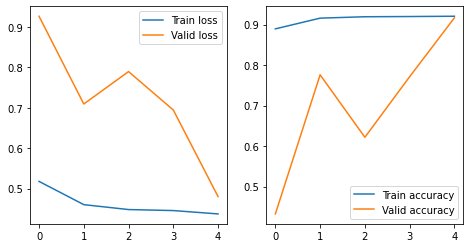

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history1.epoch, history1.history["loss"], label="Train loss")
plt.plot(history1.epoch, history1.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history1.epoch, history1.history["accuracy"], label="Train accuracy")
plt.plot(history1.epoch, history1.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.show()

In [ ]:
transfer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 262, 262, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 3136        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## U-Net Model

The UNET architecture contains two paths. First path is the contraction path (also called the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. 

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, concatenate,Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization,MaxPool2D,Dense,Input,Concatenate
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import cv2
from skimage.transform import resize

In [ ]:
inputs = Input((128,128,1))
#zeropadding = tf.keras.layers.ZeroPadding2D(padding=1)(inputs)
bn1 = BatchNormalization(momentum=0.9)(inputs)
conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

bn2 = BatchNormalization(momentum=0.9)(pool1)
conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn2)
drop12 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop12)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

bn3 = BatchNormalization(momentum=0.9)(pool2)
conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn3)
drop13 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop13)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

bn4 = BatchNormalization(momentum=0.9)(pool3)
conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn4)
conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

bn5 = BatchNormalization(momentum=0.9)(pool4)
conv5 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn5)
conv5 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

bn6 = BatchNormalization(momentum=0.9)(drop5)
up6 = Conv2D(256, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn6))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

bn7 = BatchNormalization(momentum=0.0)(conv6)
up7 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn7))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

bn9 = BatchNormalization(momentum=0.0)(conv7)
up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn9))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

bn8 = BatchNormalization(momentum=0.0)(conv8)
up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D(1,(1,1), activation = 'sigmoid')(conv9)

model_unet = Model(inputs=[inputs],outputs=[conv10])
optimizer1 = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_unet.compile(optimizer = Adam(lr = 0.0001), loss = iou_bce_loss, metrics = ['accuracy',mean_iou])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
folder = '/content/drive/My Drive/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=42, image_size=128, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=42, image_size=128, shuffle=False, predict=False)

In [ ]:
model_unet.load_weights('/content/drive/My Drive/model_unet_weights6.h5')
history3 = model_unet.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=2)
model_unet.save_weights('/content/drive/My Drive/model_unet_weights8.h5')

Epoch 1/2
57/57 [==============================] - 1916s 34s/step - loss: 0.2912 - accuracy: 0.9595 - mean_iou: 0.7167 - val_loss: 0.2922 - val_accuracy: 0.9559 - val_mean_iou: 0.6721 - lr: 0.0010
Epoch 2/2
57/57 [==============================] - 1832s 32s/step - loss: 0.2849 - accuracy: 0.9608 - mean_iou: 0.7123 - val_loss: 0.2899 - val_accuracy: 0.9571 - val_mean_iou: 0.6862 - lr: 9.9606e-04


In [ ]:
model_unet.load_weights('/content/drive/My Drive/model_unet_weights6.h5')
history3 = model_unet.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=4)
model_unet.save_weights('/content/drive/My Drive/model_unet_weights8.h5')

57/57 [==============================] - 1953s 34s/step - loss: 0.2996 - accuracy: 0.9586 - mean_iou: 0.7001 - val_loss: 0.2858 - val_accuracy: 0.9559 - val_mean_iou: 0.7037 - lr: 0.0010
Epoch 2/4
57/57 [==============================] - 1845s 32s/step - loss: 0.2758 - accuracy: 0.9628 - mean_iou: 0.7289 - val_loss: 0.2849 - val_accuracy: 0.9538 - val_mean_iou: 0.7080 - lr: 9.9606e-04
Epoch 3/4
43/57 [=====================>........] - ETA: 7:05 - loss: 0.2744 - accuracy: 0.9637 - mean_iou: 0.7309

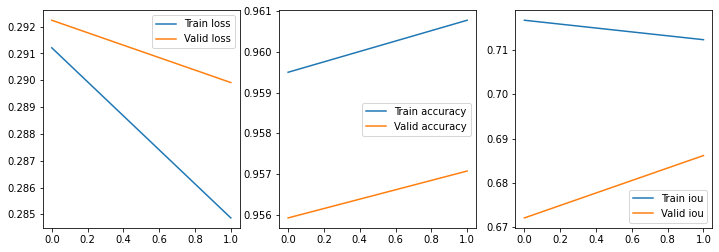

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history3.epoch, history3.history["loss"], label="Train loss")
plt.plot(history3.epoch, history3.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history3.epoch, history3.history["accuracy"], label="Train accuracy")
plt.plot(history3.epoch, history3.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history3.epoch, history3.history["mean_iou"], label="Train iou")
plt.plot(history3.epoch, history3.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

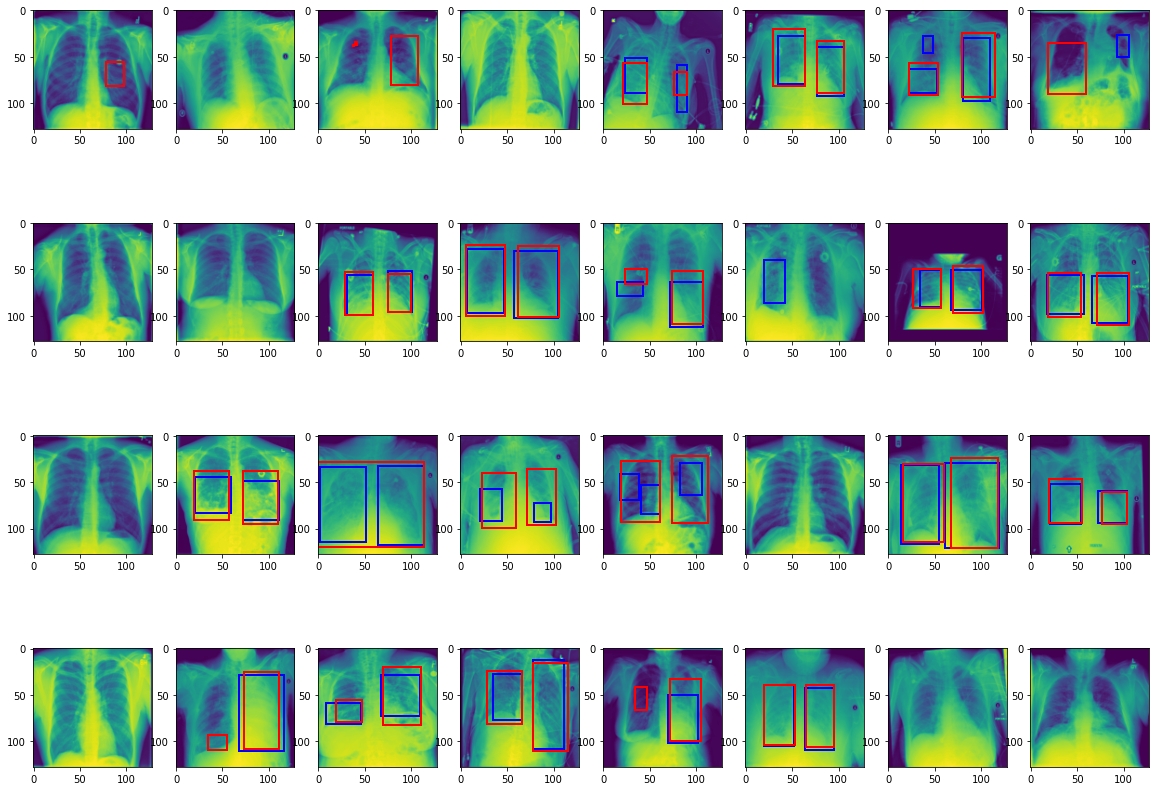

In [ ]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model_unet.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            conf = np.mean(pred[y:y+height, x:x+width])
            if conf>0.5:
              axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
        if axidx==32:
          break
    plt.show()
    # only plot one batch
    break

In [ ]:
folder = 'stage_2_test_images'
test_filenames = os.listdir(folder)
# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=2, image_size=128, shuffle=False, predict=True)

n test samples: 3000


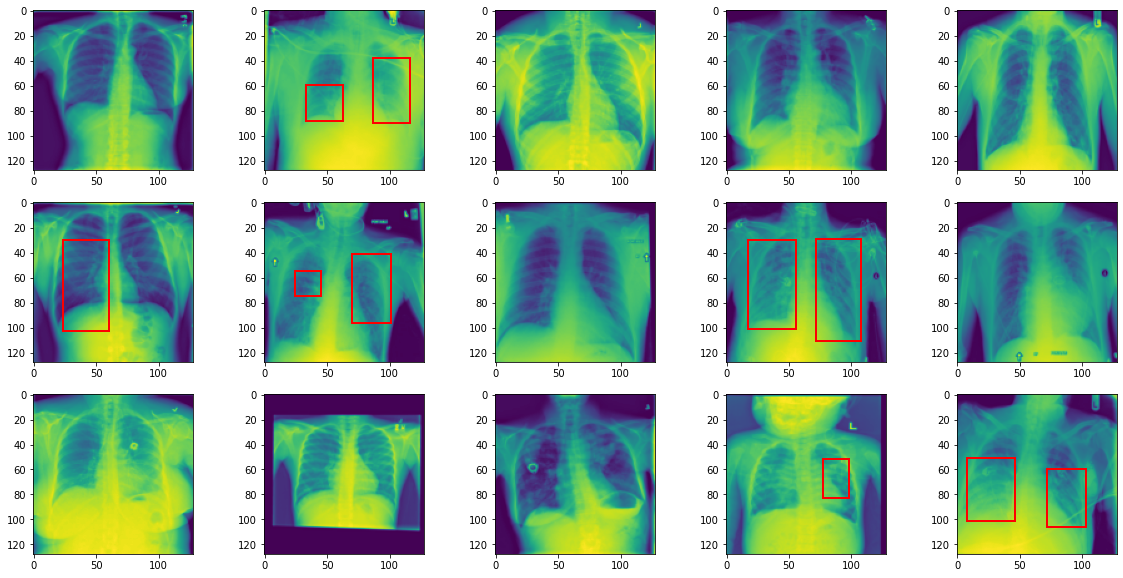

In [ ]:
print('n test samples:', len(test_filenames))
f, axarr = plt.subplots(3, 5, figsize=(20,10))
axarr = axarr.ravel()
axidx = 0
# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model_unet.predict(imgs)
    #axarr[axidx].imshow(resize(imgs[:, :, 0],(128, 128),mode='reflect'))
    # loop through batch
    for img,pred, filename in zip(imgs,preds, filenames):
        # resize predicted mask
        #pred = resize(pred, (1024, 1024), mode='reflect')
        axarr[axidx].imshow(img[:, :, 0])
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.7
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            if conf>0.76:
              predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
              axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    #print("--------------------------------------------------------------------------")
    #print(axidx)
    #print(predictionString)
    axidx += 1
    if axidx >= 15: #len(test_filenames)
        break
plt.show()

## Model Performance :

In this project , implemented three different models (ResNet,U-Net and Dense Net) to identify the pneumonia in lungs.These all three models evaluated with different hyper parameters and different sets of images. Initially we started the evaluation with below 1000 images and kept on increasing the images and captured the Model Accuracy and validation accuracy.For model evaluation ,we have used Jaccord index and Mean IOU technique.In Initial stage , we have achieved the accuracy of 94%,92% and 96% using Resnet,Dense and Unet respectively. 
To further improve the performance of models, we performed parameter tuning  like modifying learning rate, batch size , dropout and batch normalization techniques also increased the network size and optimizer as adam. After Parameter tuning , we have achieved the accuracy of 94%,92% and 96% using Resnet,Dense and Unet respectively. All three models are performing well , compared to others U-Net models have outperformed.

